In [777]:
# Import libraries
import random
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Layer, Input, Lambda, Activation
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model

In [778]:
# Extract data
data = pd.read_csv('../../ETL/Load/stockData.csv', header=(0), sep=';')

In [779]:
data

,TICKER,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
0,ABEV3,2014-07-01,21.706832,2.906275,0.258062,0.634963,0.029252,5.601715,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.376079,0
1,ABEV3,2014-08-01,22.676506,2.906275,0.258062,0.634963,0.028001,5.851952,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.278858,0
2,ABEV3,2014-09-01,22.219375,2.906275,0.258062,0.634963,0.028577,5.733983,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.327730,0
3,ABEV3,2014-10-01,22.718062,2.906275,0.258062,0.634963,0.027950,5.862676,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.286358,0
4,ABEV3,2014-11-01,23.216752,2.906275,0.258062,0.634963,0.027349,5.991369,2.047001e+10,2.894055e+09,1.513876e+10,1.191462,0.75000,0.211723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,YDUQ3,2023-08-01,-102.086973,10.561267,-0.018731,-0.677386,0.006635,1.912161,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.501691,0
11359,YDUQ3,2023-09-01,-99.581156,10.561267,-0.018731,-0.677386,0.006802,1.865226,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.529218,0
11360,YDUQ3,2023-10-01,-88.856255,10.561267,-0.018731,-0.677386,0.007623,1.664341,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.390872,0
11361,YDUQ3,2023-11-01,-100.683712,10.561267,-0.018731,-0.677386,0.006728,1.885877,2.100461e+09,5.040497e+09,2.802750e+08,1.896389,-0.19782,-0.531334,0


In [780]:
# Describe original data
data.describe()

,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
count,11363.000000,11363.000000,11363.000000,11363.000000,11363.000000,11363.000000,1.136300e+04,1.136300e+04,1.136300e+04,1.136300e+04,11363.000000,11363.000000,11363.000000
mean,-531.551791,33.890718,-0.025214,0.338965,4.741799,51.896740,1.533774e+10,1.978991e+10,3.818294e+09,inf,3.918511,0.163647,0.097333
std,15684.407655,508.396423,3.095612,2.592203,78.270801,1018.558948,2.748858e+10,6.773164e+10,2.313760e+10,NaN,91.344843,0.630312,0.296424
min,-765054.927367,-664.507625,-63.574215,-66.250000,-0.000000,-1249.308423,6.943000e+06,0.000000e+00,4.469333e+04,7.070553e-02,-111.585170,-0.995833,0.000000
25%,2.251269,5.016680,0.036619,0.000000,0.003078,0.682970,1.824915e+09,1.206523e+09,2.530056e+08,1.164050e+00,0.170000,-0.176193,0.000000
50%,8.823358,9.895760,0.120799,0.282966,0.022017,1.575433,5.417423e+09,3.935138e+09,7.231214e+08,1.629700e+00,0.920250,0.069011,0.000000
75%,23.070468,17.793117,0.197393,0.594902,0.058745,3.689210,1.594072e+10,1.333942e+10,1.821185e+09,2.419938e+00,2.175100,0.362940,0.000000
max,12635.786682,14885.774638,11.746541,45.098061,2196.206875,38484.339615,2.149780e+11,7.532630e+11,4.176953e+11,inf,2770.000000,10.778047,1.000000


In [781]:
# Separate train and test data
# Train: first 8 years
# Test: last 2 years

cutoff_year = 2021

data['DATE'] = pd.to_datetime(data['DATE'])
data_train = data[data['DATE'].dt.year <= cutoff_year]
data_test = data[data['DATE'].dt.year > cutoff_year]

In [782]:
data_train = data[data['DATE'].dt.year <= cutoff_year]
data_test = data[data['DATE'].dt.year > cutoff_year]

In [783]:
# Function to remove outliers using std
def remove_outliers_std(data_train, data_test, column, factor = 3):
    data_std = data_train[column].std()
    data_mean = data_train[column].mean()
    lower_bound = data_mean - factor * data_std
    upper_bound = data_mean + factor * data_std
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

# Function to remove outliers using IQR
def remove_outliers_iqr(data_train, data_test, column, factor = 1.5):
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

In [784]:
# List of features and the class column
features = data.columns.tolist()[2:-1]
binary_class = data.columns.tolist()[-1]

# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)

# Clean outliers from data
method = 'iqr' # std or iqr
factor = 6

if method == 'std':
    for feature in features:
        data_train, data_test = remove_outliers_std(data_train, data_test, feature, factor)
elif method == 'iqr':
    for feature in features:
        data_train, data_test = remove_outliers_iqr(data_train, data_test, feature, factor)

In [785]:
# Describe train data without outliers
data_train.describe()

,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
count,6347,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6347.000000,6.347000e+03,6.347000e+03,6.347000e+03,6347.000000,6347.000000,6347.000000,6347.000000
mean,2017-11-26 04:57:12.676855296,17.527371,13.000697,0.114881,0.382534,0.038905,2.815642,9.494696e+09,8.542558e+09,1.232545e+09,1.944675,1.191137,0.197037,0.101465
min,2013-01-01 00:00:00,-129.615890,-19.123328,-0.734395,-3.202127,-0.000000,-12.734168,1.036100e+07,0.000000e+00,1.176395e+07,0.106487,-9.420000,-0.911268,0.000000
25%,2015-10-01 00:00:00,4.809240,6.333591,0.050398,0.079756,0.005896,0.805356,1.663480e+09,1.228257e+09,2.428858e+08,1.201116,0.350600,-0.126779,0.000000
50%,2018-02-01 00:00:00,12.824537,10.017375,0.119103,0.315166,0.022572,1.708274,4.432090e+09,3.534545e+09,6.440956e+08,1.674110,1.050000,0.099008,0.000000
75%,2020-01-01 00:00:00,25.383598,17.093786,0.190104,0.594902,0.052109,3.465785,1.097648e+10,1.118890e+10,1.453851e+09,2.394031,1.962780,0.391284,0.000000
max,2021-12-01 00:00:00,157.948039,68.721762,1.077140,3.721054,0.360459,19.468781,1.008661e+11,6.590670e+10,1.016882e+10,8.138526,11.422080,3.524096,1.000000
std,NaN,29.837127,11.382881,0.183755,0.547647,0.049640,3.301920,1.372152e+10,1.232247e+10,1.710586e+09,1.146805,2.144226,0.538727,0.301968


In [786]:
# Describe test data without outliers
data_test.describe()

,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
count,1740,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000,1740.000000,1.740000e+03,1.740000e+03,1.740000e+03,1740.000000,1740.000000,1740.000000,1740.000000
mean,2022-12-26 08:28:57.931034624,14.050839,11.536844,0.164054,0.365136,0.051463,2.352757,1.113130e+10,1.074184e+10,1.587576e+09,1.964724,1.564557,0.043356,0.044828
min,2022-01-01 00:00:00,-129.330435,-44.434689,-0.544953,-2.428702,-0.000000,-2.014198,6.943000e+06,0.000000e+00,1.176409e+07,0.070706,-4.911970,-0.995833,0.000000
25%,2022-07-01 00:00:00,4.392125,4.448813,0.074769,0.052706,0.006539,0.787417,2.593505e+09,1.976992e+09,4.186071e+08,1.309137,0.524220,-0.208574,0.000000
50%,2023-01-01 00:00:00,9.103279,9.062375,0.141892,0.289964,0.023701,1.590059,7.909456e+09,6.276182e+09,9.552082e+08,1.663042,1.146850,0.022810,0.000000
75%,2023-07-01 00:00:00,20.949939,15.585425,0.215820,0.566766,0.066325,2.986922,1.545620e+10,1.419864e+10,1.948209e+09,2.310015,2.163800,0.235404,0.000000
max,2023-12-01 00:00:00,158.958022,61.243413,0.915534,1.886858,0.362852,13.895744,6.053730e+10,6.590670e+10,1.004250e+10,10.212709,9.040000,2.047620,1.000000
std,NaN,24.988186,11.135142,0.180802,0.502666,0.070085,2.407843,1.091857e+10,1.234197e+10,1.821735e+09,1.231124,1.900400,0.405692,0.206985


In [787]:
# Change data to numpy
data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

# Get number of rows and columns
ncol = data.shape[1]

# Get arrays for features and class
y_train = data_train[:,-1]
X_train = data_train[:,2:ncol-2]
y_test = data_test[:,-1]
X_test = data_test[:,2:ncol-2]

In [788]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [789]:
# Subtractive Clustering:
def subtractive_clustering(X, number_of_rules, radius=0.2):
    # Compute pairwise distances between points
    d = pdist(X, 'euclidean')
    d_squareform = squareform(d) # Distance matrix between points
    # Calculate potential for each point
    potential = np.sum(np.exp(-d_squareform**2 / (radius/2**2)), axis=1)
    # Sort by potential and select highest point
    idx = np.argsort(potential)[::-1][0]
    # Start rule center with highest potential point as a cluster center
    rule_centers = X[idx]
    # If number of rules is larger than 1, continue algorithym for the following cluster centers
    if number_of_rules > 1:
        for i in range(number_of_rules-1):
            potential_star = potential[idx]
            X_star = X[idx]
            distances = np.sqrt(np.sum((X - X_star) ** 2, axis=1))
            potential = potential - potential_star*np.exp(-distances**2 / (radius/2**2))
            X_star = X[idx]
            idx = np.argsort(potential)[::-1][0]
            rule_centers = np.vstack((rule_centers, X[idx]))
    return rule_centers.T

In [698]:
# Get Rule Centers (means of gaussian membership functions)

# Define dataset dimensions
input_dim = 11
num_rules = 2

# Apply clustering to get rule centers
rule_centers = subtractive_clustering(X_train, num_rules, radius=0.2)
print("Rule Centers:", rule_centers)

Rule Centers: [[-0.43215642 -0.69909438]
 [ 0.36001005  2.63572389]
 [ 0.4665462  -0.90885386]
 [-0.19715553 -0.69855945]
 [ 0.40608954 -0.78340812]
 [-0.5709638  -0.80121279]
 [ 4.562324    1.53468151]
 [-0.69330488  2.68499311]
 [ 2.38804227  0.05232496]
 [ 1.55384715 -0.31428814]
 [ 1.04421798 -1.60069766]]


In [790]:
# Convert y to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [791]:
# Upsample 1 Class
# Convert X_train and y_train to DataFrame and Series, respectively
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Split the dataset by class
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Resample minority class to match the majority class size
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     
                                      n_samples=len(X_train_majority),  
                                      random_state=42)

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,     
                                      n_samples=len(y_train_majority),  
                                      random_state=42)

# Combine majority class and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [792]:
# Convert y to integer
y_train = y_train.astype(int)

In [702]:
class FuzzificationLayer(Layer):
    def __init__(self, num_rules, initial_means, **kwargs):
        super(FuzzificationLayer, self).__init__(**kwargs)
        self.num_rules = num_rules
        self.initial_means = tf.constant(initial_means, dtype=tf.float32)  # Initial means

    def build(self, input_shape):
        num_features = input_shape[-1]

        # Ensure means match the dimensions
        assert self.initial_means.shape == (input_dim, self.num_rules), \
    f"Expected shape {(input_dim, self.num_rules)}, but got {self.initial_means.shape}"
        
        # Trainable parameters for Gaussian membership functions
        self.means = self.add_weight(
            shape=(num_features, self.num_rules),
            initializer=tf.keras.initializers.Constant(self.initial_means), # Initialize with rule centers
            trainable=True,
            name='means'
        )
        self.stds = self.add_weight(
            shape=(num_features, self.num_rules),
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True,
            name='stds'
        )

    def call(self, inputs):
        # Expand dimensions for broadcasting
        inputs_expanded = tf.expand_dims(inputs, axis=-1)  # (batch_size, num_features, 1)
        # Gaussian membership functions
        membership_values = tf.exp(
            -((inputs_expanded - self.means) ** 2) / (2 * (self.stds ** 2))
        )
        return membership_values


class RuleLayer(Layer):
    def call(self, inputs):
        # Multiply membership values across features for each rule
        # Inputs: (batch_size, num_features, num_rules)
        rule_strengths = tf.reduce_prod(inputs, axis=1)  # (batch_size, num_rules)
        return rule_strengths


class NormalizationLayer(Layer):
    def call(self, inputs):
        # Normalize rule strengths
        # Inputs: (batch_size, num_rules)
        normalized_weights = inputs / tf.reduce_sum(inputs, axis=1, keepdims=True)
        return normalized_weights


class WeightedCombinationLayer(Layer):
    def __init__(self, input_dim, num_rules, **kwargs):
        super(WeightedCombinationLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.num_rules = num_rules

    def build(self, input_shape):
        # Initialize weights for each rule and input dimension
        self.rule_weights = self.add_weight(
            shape=(self.input_dim, self.num_rules),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
            name="rule_weights"
        )
        # Initialize biases for each rule
        self.biases = self.add_weight(
            shape=(self.num_rules,),
            initializer="zeros",
            trainable=True,
            name="biases"
        )

    def call(self, inputs):
        normalized_weights, original_inputs = inputs  # [batch_size, num_rules], [batch_size, input_dim]
        
        # 1. Dot product of the original inputs with the rule weights
        dot_product = tf.matmul(original_inputs, self.rule_weights)  # Shape: [batch_size, 2]

        # 2. Add the biases
        dot_product_with_bias = dot_product + self.biases  # Shape: [batch_size, 2]

        # 3. Multiply everything by the normalized weights
        # To broadcast correctly, expand normalized_weights to match the shape
        normalized_weights_expanded = tf.expand_dims(normalized_weights, axis=-1)  # Shape: [batch_size, num_rules, 1]

        # Sum over the rules dimension after scaling
        output = normalized_weights * dot_product_with_bias  # Element-wise multiplication, shape: [batch_size, num_rules]
        
        return output  # Final shape: [batch_size, 2]

def build_anfis_model(input_dim, num_rules):
    # Input layer
    inputs = Input(shape=(input_dim,), name='InputLayer')

    # Layer 1: Fuzzification
    fuzzification = FuzzificationLayer(num_rules=num_rules, initial_means=rule_centers, name='FuzzificationLayer')(inputs)

    # Layer 2: Rule Strengths
    rule_strengths = RuleLayer(name='RuleLayer')(fuzzification)

    # Layer 3: Normalize Rule Strengths
    normalized_weights = NormalizationLayer(name='NormalizationLayer')(rule_strengths)

    # Layer 4: Weighted Combination
    weighted_combination = WeightedCombinationLayer(input_dim, num_rules, name='WeightedCombinationLayer')(
        [normalized_weights, inputs]
    )

    # Layer 5: Defuzzification
    outputs = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), name="OutputLayerSum")(weighted_combination)
    #outputs_sum = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), name="OutputLayerSum")(weighted_combination)
    #outputs = Activation('sigmoid', name='OutputLayer')(outputs_sum)
    
    

    # Build model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [703]:
# Build model
anfis_model = build_anfis_model(input_dim, num_rules)

# Compile the model
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
anfis_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

anfis_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)       │ (None, 11)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FuzzificationLayer            │ (None, 11, 2)             │              44 │ InputLayer[0][0]           │
│ (FuzzificationLayer)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ RuleLayer (RuleLayer)         │ (None, 2)                 │               0 │ FuzzificationLayer[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ NormalizationLayer            │ (None, 2)                 │               0 │ RuleLayer[0][0]            │
│ (NormalizationLayer)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ WeightedCombinationLayer      │ (None, 2)                 │              24 │ NormalizationLayer[0][0],  │
│ (WeightedCombinationLayer)    │                           │                 │ InputLayer[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OutputLayerSum (Lambda)       │ (None, 1)                 │               0 │ WeightedCombinationLayer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 68 (272.00 B)

 Trainable params: 68 (272.00 B)

 Non-trainable params: 0 (0.00 B)

In [704]:
loss, mse = anfis_model.evaluate(X_train_balanced, y_train_balanced, verbose=1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.5198 - loss: 1.9518


In [705]:
# Train the model
histAnfis = anfis_model.fit(X_train_balanced[:], y_train_balanced[:],  epochs=20, verbose=2)

Epoch 1/20
357/357 - 1s - 2ms/step - accuracy: 0.6203 - loss: 0.2765
Epoch 2/20
357/357 - 0s - 667us/step - accuracy: 0.6481 - loss: 0.2229
Epoch 3/20
357/357 - 0s - 647us/step - accuracy: 0.6472 - loss: 0.2221
Epoch 4/20
357/357 - 0s - 644us/step - accuracy: 0.6457 - loss: 0.2219
Epoch 5/20
357/357 - 0s - 642us/step - accuracy: 0.6498 - loss: 0.2209
Epoch 6/20
357/357 - 0s - 675us/step - accuracy: 0.6482 - loss: 0.2206
Epoch 7/20
357/357 - 0s - 662us/step - accuracy: 0.6540 - loss: 0.2183
Epoch 8/20
357/357 - 0s - 644us/step - accuracy: 0.6511 - loss: 0.2193
Epoch 9/20
357/357 - 0s - 648us/step - accuracy: 0.6475 - loss: 0.2218
Epoch 10/20
357/357 - 0s - 646us/step - accuracy: 0.6587 - loss: 0.2181
Epoch 11/20
357/357 - 0s - 648us/step - accuracy: 0.6550 - loss: 0.2170
Epoch 12/20
357/357 - 0s - 658us/step - accuracy: 0.6554 - loss: 0.2155
Epoch 13/20
357/357 - 0s - 702us/step - accuracy: 0.6616 - loss: 0.2158
Epoch 14/20
357/357 - 0s - 974us/step - accuracy: 0.6649 - loss: 0.2149
Epo

Text(0.5, 1.0, 'Loss per epoch')

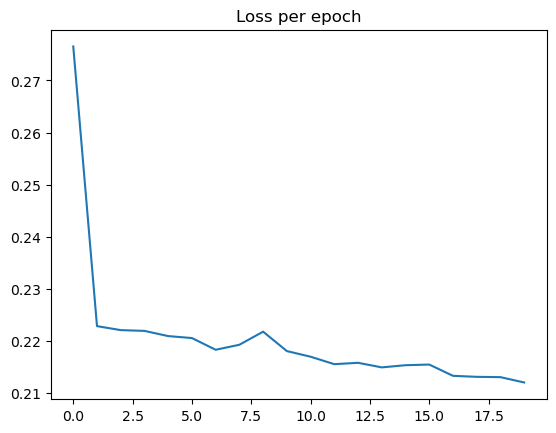

In [706]:
plt.plot(histAnfis.history['loss'])
plt.title("Loss per epoch")

In [793]:
# Scale the test data
X_test = scaler.transform(X_test)

In [794]:
# Run model prediction
y_pred = anfis_model.predict(X_test)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


In [709]:
# Get Asset Appreciation per Cuttof Point
cutoff_points = np.linspace(min(y_pred), max(y_pred), 100)

average_appreciation = []
class1_count = []

# For each cutoff point, get number of assets and average appreciation
for cutoff in cutoff_points:
    y_pred_appreciation = y_pred.copy()
    # Treat predicted array
    y_pred_appreciation[np.isnan(y_pred_appreciation)] = 0
    y_pred_appreciation[y_pred>=cutoff] = 1
    y_pred_appreciation[y_pred<cutoff] = 0
    y_pred_appreciation = np.sign(y_pred_appreciation.flatten())
    y_pred_appreciation.astype(int)

    # Add to list the number of class 1 assets
    class1_count.append(sum(y_pred_appreciation))
    data_test_period = np.array([row for row in data_test[y_pred_appreciation==1]])
    # Add the average appreciation of the assets to list if there are any
    if len(data_test_period):
        average_appreciation.append(np.mean(data_test_period[:,-2]))
    else:
        average_appreciation.append(0.0)
    

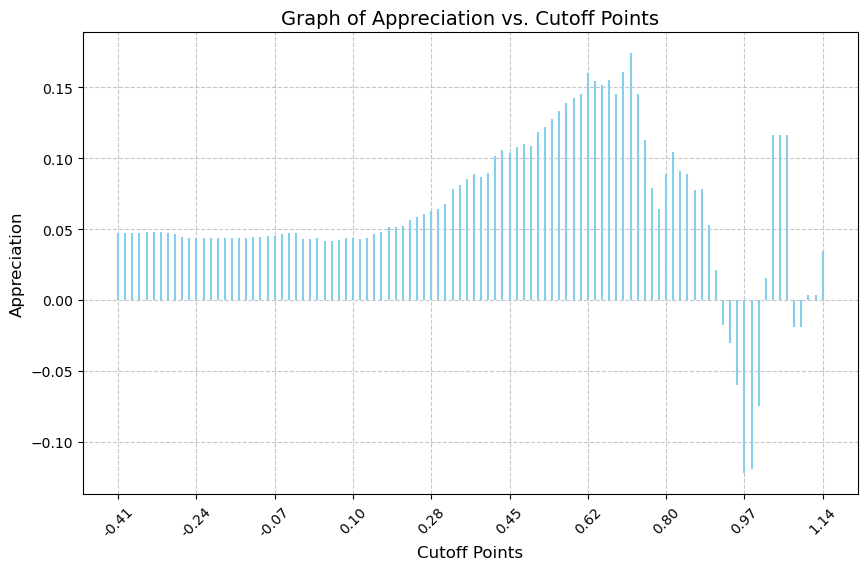

In [770]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.stem(cutoff_points, average_appreciation, linefmt='skyblue', markerfmt=' ', basefmt=" ")

# Adding labels and title
plt.xlabel('Cutoff Points', fontsize=12)
plt.ylabel('Appreciation', fontsize=12)
plt.title('Graph of Appreciation vs. Cutoff Points', fontsize=14)

# Determine 10 equally spaced indices for the x-axis
indices = np.linspace(0, len(cutoff_points) - 1, 10, dtype=int)
spaced_cutoff_points = np.squeeze(cutoff_points[indices])
spaced_labels = [f"{float(x):.2f}" for x in spaced_cutoff_points]

# Optional: Add grid and customize ticks
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(spaced_cutoff_points, spaced_labels, rotation=45)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

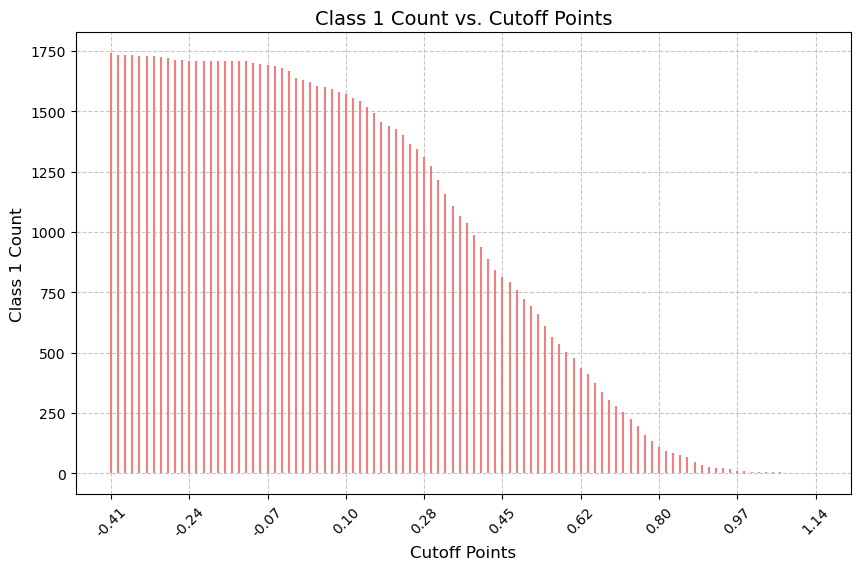

In [711]:
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.stem(cutoff_points, class1_count, linefmt='lightcoral', markerfmt=' ', basefmt=" ")

# Adding labels and title
plt.xlabel('Cutoff Points', fontsize=12)
plt.ylabel('Class 1 Count', fontsize=12)
plt.title('Class 1 Count vs. Cutoff Points', fontsize=14)

# Determine 10 equally spaced indices for the x-axis
indices = np.linspace(0, len(cutoff_points) - 1, 10, dtype=int)
spaced_cutoff_points = np.squeeze(cutoff_points[indices])
spaced_labels = [f"{x:.2f}" for x in spaced_cutoff_points]

# Optional: Add grid and customize ticks
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(spaced_cutoff_points, spaced_labels, rotation=45)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [712]:
# Get ideal cutoff point
# Generate cutoff points
cutoff_points = np.linspace(min(y_pred), max(y_pred), 100)

# Initialize lists to store rates
true_positive_rates = []
true_negative_rates = []

# Calculate rates for each cutoff
for cutoff in cutoff_points:
    # Classify predictions based on the cutoff
    y_pred_classes = np.where(y_pred.flatten() >= cutoff, 1, 0)
    
    # Compute true positives and true negatives
    true_positives = np.sum((y_pred_classes == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred_classes == 0) & (y_test == 0))
    
    # Total positives and negatives in the true labels
    total_positives = np.sum(y_test == 1)
    total_negatives = np.sum(y_test == 0)
    
    # True positive rate (TPR) and true negative rate (TNR)
    tpr = true_positives / total_positives if total_positives > 0 else 0
    tnr = true_negatives / total_negatives if total_negatives > 0 else 0
    
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

# Find the cutoff where the two curves cross
# This happens when |TPR - TNR| is minimized
tpr_array = np.array(true_positive_rates)
tnr_array = np.array(true_negative_rates)
cutoff_cross = cutoff_points[np.argmin(np.abs(tpr_array - tnr_array))]

In [724]:
round(cutoff_cross[0],3)

0.546

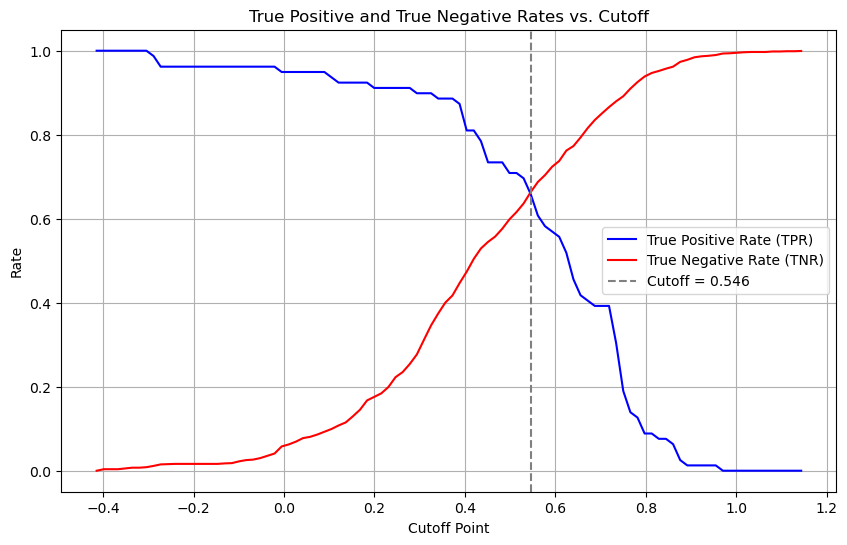

In [727]:
# Plot the TPR and TNR
plt.figure(figsize=(10, 6))
plt.plot(cutoff_points, true_positive_rates, label='True Positive Rate (TPR)', color='blue')
plt.plot(cutoff_points, true_negative_rates, label='True Negative Rate (TNR)', color='red')
plt.axvline(cutoff_cross, color='gray', linestyle='--', label=f'Cutoff = {cutoff_cross[0]:.3f}')
plt.xlabel('Cutoff Point')
plt.ylabel('Rate')
plt.title('True Positive and True Negative Rates vs. Cutoff')
plt.legend()
plt.grid()
plt.show()

In [795]:
# Save PRedicted Signals for future use
y_pred_signal = y_pred.copy()

# Treat predicted array
y_pred[y_pred>=cutoff_cross] = 1
y_pred[y_pred<cutoff_cross] = 0
y_pred = np.sign(y_pred.flatten())
y_pred.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [729]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

Accuracy: 0.6632183908045977
Precision: 0.0851063829787234
Recall (Sensitivity): 0.6582278481012658
F1-Score: 0.15072463768115943


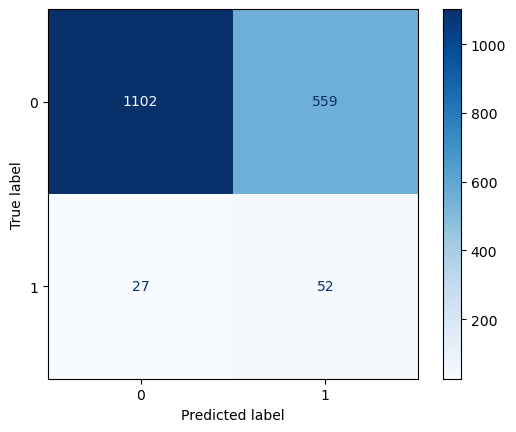

In [730]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [768]:
data_test_period = np.array([row for row in data_test[y_pred==1] if row[1].year == 2022])
np.mean(1+data_test_period[:,-2])-1

0.12995457498054952

In [769]:
for month in range(1,13):
    data_test_period = np.array([row for row in data_test[y_pred==1] if row[1].year == 2022 and row[1].month == month]  )
    print(np.mean(1+data_test_period[:,-2])-1)

-0.06392103160345541
-0.0881991868941886
-0.1468654156809076
-0.03967301115862709
0.014750704073285714
0.3523393809994406
0.20755582134187844
0.12333794837043399
0.14055369966609566
0.0967075440758931
0.27916699818265767
0.4202554225171178


In [796]:
data_test

array([['ALOS3', Timestamp('2023-11-01 00:00:00'), 59.12058647016874,
        ..., 0.5883, -0.1832009567545116, 0],
       ['ALOS3', Timestamp('2023-12-01 00:00:00'), 61.36245232052914,
        ..., 0.5883, -0.2629271643157908, 0],
       ['AMER3', Timestamp('2023-01-01 00:00:00'), 64.44069254038746,
        ..., 0.7201, -0.5314285714285714, 0],
       ...,
       ['YDUQ3', Timestamp('2023-10-01 00:00:00'), -88.85625461661317,
        ..., -0.19782, -0.3908717635485069, 0],
       ['YDUQ3', Timestamp('2023-11-01 00:00:00'), -100.6837120640436,
        ..., -0.19782, -0.5313335383367701, 0],
       ['YDUQ3', Timestamp('2023-12-01 00:00:00'), -112.36081707379368,
        ..., -0.19782, -0.6322509759557378, 0]], dtype=object)

In [799]:
data_test

,TICKER,DATE,PE,BVPS,ROE,DPR,DY,PBR,CA,GROSS_DEBT,ANS,CURRENT_RATIO,EPS,APPRECIATION,CLASS
0,ALOS3,2023-11-01,59.120586,20.860601,0.028201,0.459067,0.007765,1.667289,3265974000.0,0.0,377603263.640999,3.215209,0.5883,-0.183201,0
1,ALOS3,2023-12-01,61.362452,20.860601,0.028201,0.459067,0.007481,1.730512,3265974000.0,0.0,377603263.640999,3.215209,0.5883,-0.262927,0
2,AMER3,2023-01-01,64.440693,21.069509,0.034177,-0.0,-0.0,2.202412,21912888000.0,12340751000.0,755165949.173726,1.643033,0.7201,-0.531429,0
3,AMER3,2023-02-01,36.823253,21.069509,0.034177,-0.0,-0.0,1.258521,21912888000.0,12340751000.0,755165949.173726,1.643033,0.7201,-0.49,0
4,AMER3,2023-03-01,36.823253,21.069509,0.034177,-0.0,-0.0,1.258521,21912888000.0,12340751000.0,755165949.173726,1.643033,0.7201,-0.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,YDUQ3,2023-08-01,-102.086973,10.561267,-0.018731,-0.677386,0.006635,1.912161,2100461000.0,5040497000.0,280274997.47245,1.896389,-0.19782,-0.501691,0
1736,YDUQ3,2023-09-01,-99.581156,10.561267,-0.018731,-0.677386,0.006802,1.865226,2100461000.0,5040497000.0,280274997.47245,1.896389,-0.19782,-0.529218,0
1737,YDUQ3,2023-10-01,-88.856255,10.561267,-0.018731,-0.677386,0.007623,1.664341,2100461000.0,5040497000.0,280274997.47245,1.896389,-0.19782,-0.390872,0
1738,YDUQ3,2023-11-01,-100.683712,10.561267,-0.018731,-0.677386,0.006728,1.885877,2100461000.0,5040497000.0,280274997.47245,1.896389,-0.19782,-0.531334,0


In [798]:
# Append results to data_test and save
data_test = pd.DataFrame(data_test, columns=data.columns)

data_test['SIGNAL'] = y_pred_signal
data_test['CLASS_PRED'] = y_pred.astype(int)

# Save results
data_test.to_csv("anfis_test_results.csv", sep=';', decimal='.', encoding='ISO-8859-1', index=False)